# Setup

In [1]:
import os
from datetime import datetime,timedelta 

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm_notebook


mpl.rcParams['figure.figsize'] = (20, 7)
mpl.rcParams['axes.grid'] = False

# Hotel Dataset

In [2]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

df['DOA'] = pd.to_datetime(df['DOA'])
df['ROH'] = df['ROH']/df['Rooms']
# df = df.drop(columns=['Rooms'])
df = df.replace([np.inf, -np.inf], np.nan)

In [3]:
df.isnull().sum()

DOA         0
DBA         0
LAR      5040
ADR      4950
Rooms       0
ROH         0
dtype: int64

In [4]:
df = df[~df['LAR'].isna()]
df = df[~df['ADR'].isna()]
df = df[~df['ROH'].isna()]

In [5]:
df.head(10)

,DOA,DBA,LAR,ADR,Rooms,ROH
0,2018-01-01,89.0,39.6,39.60,43.0,0.860465
1,2018-01-01,88.0,39.6,39.60,43.0,0.813953
2,2018-01-01,87.0,39.6,40.50,43.0,0.790698
3,2018-01-01,86.0,39.6,40.50,43.0,0.767442
4,2018-01-01,85.0,48.6,48.60,43.0,0.767442
5,2018-01-01,84.0,48.6,50.85,43.0,0.744186
6,2018-01-01,83.0,53.1,53.10,43.0,0.744186
7,2018-01-01,82.0,53.1,53.10,43.0,0.744186
8,2018-01-01,81.0,53.1,56.10,43.0,0.744186
9,2018-01-01,80.0,71.1,71.10,43.0,0.744186


In [6]:
df.describe(include='all').transpose()

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
DOA,60660,674,2018-07-17,90,2018-01-01,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DBA,60660,NaN,NaT,NaN,NaT,NaT,44.5,25.9794,0,22,44.5,67,89
LAR,60660,NaN,NaT,NaN,NaT,NaT,71.4188,38.3908,25.92,48.6,62.1,75.6,264.6
ADR,60660,NaN,NaT,NaN,NaT,NaT,71.5229,38.4476,27.36,48.6,61.9417,75.6,264.6
Rooms,60660,NaN,NaT,NaN,NaT,NaT,51.169,2.83629,32,48,53,53,53
ROH,60660,NaN,NaT,NaN,NaT,NaT,0.447758,0.287505,0,0.207547,0.415094,0.679245,1.12766


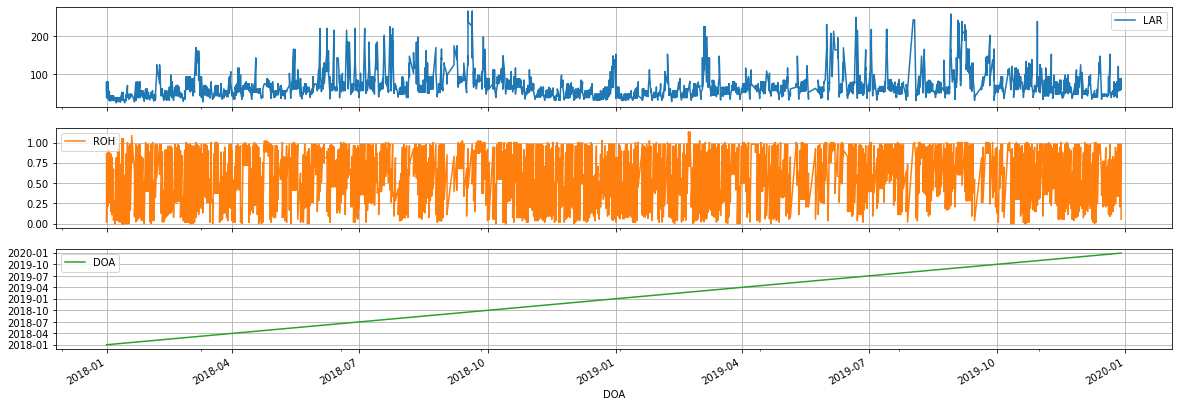

In [7]:
plot_cols = ['LAR', 'ROH', 'DOA']
plot_features = df[plot_cols]
plot_features.index = df['DOA']
_ = plot_features.plot(subplots=True,grid=True)

# plot_features = df[plot_cols][:160]
# plot_features.index = df['DOA'][:160]
# _ = plot_features.plot(subplots=True)

# Feature Engineering

In [8]:
timestamp_s = df['DOA'].map(datetime.timestamp)
df['DOW'] = df['DOA'].dt.dayofweek
df['Mon'] = df['DOA'].dt.month

# This is a hack to combine both datetime columns
df['DOA'] = df['DOA']+df['DBA'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 
df = df.set_index('DOA')

In [9]:
df.head()

,DBA,LAR,ADR,Rooms,ROH,DOW,Mon
DOA,,,,,,,
2018-01-01 00:00:00,89.0,39.6,39.6,43.0,0.860465,0,1
2018-01-01 00:16:00,88.0,39.6,39.6,43.0,0.813953,0,1
2018-01-01 00:32:00,87.0,39.6,40.5,43.0,0.790698,0,1
2018-01-01 00:48:00,86.0,39.6,40.5,43.0,0.767442,0,1
2018-01-01 01:04:00,85.0,48.6,48.6,43.0,0.767442,0,1


In [10]:
day = 24*60*60
week = 7*day
month = 30.5*day
year = (365.2425)*day

# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin']  = list(np.sin(timestamp_s * (2 * np.pi / week)))
df['Week cos']  = list(np.cos(timestamp_s * (2 * np.pi / week)))
df['Month sin'] = list(np.sin(timestamp_s * (2 * np.pi / month)))
df['Month cos'] = list(np.cos(timestamp_s * (2 * np.pi / month)))
df['Year sin']  = list(np.sin(timestamp_s * (2 * np.pi / year)))
df['Year cos']  = list(np.cos(timestamp_s * (2 * np.pi / year)))

In [11]:
df.head()

,DBA,LAR,ADR,Rooms,ROH,DOW,Mon,Week sin,Week cos,Month sin,Month cos,Year sin,Year cos
DOA,,,,,,,,,,,,,
2018-01-01 00:00:00,89.0,39.6,39.6,43.0,0.860465,0,1,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:16:00,88.0,39.6,39.6,43.0,0.813953,0,1,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:32:00,87.0,39.6,40.5,43.0,0.790698,0,1,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:48:00,86.0,39.6,40.5,43.0,0.767442,0,1,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 01:04:00,85.0,48.6,48.6,43.0,0.767442,0,1,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985


Text(0.5, 1.0, 'Time of day signal')

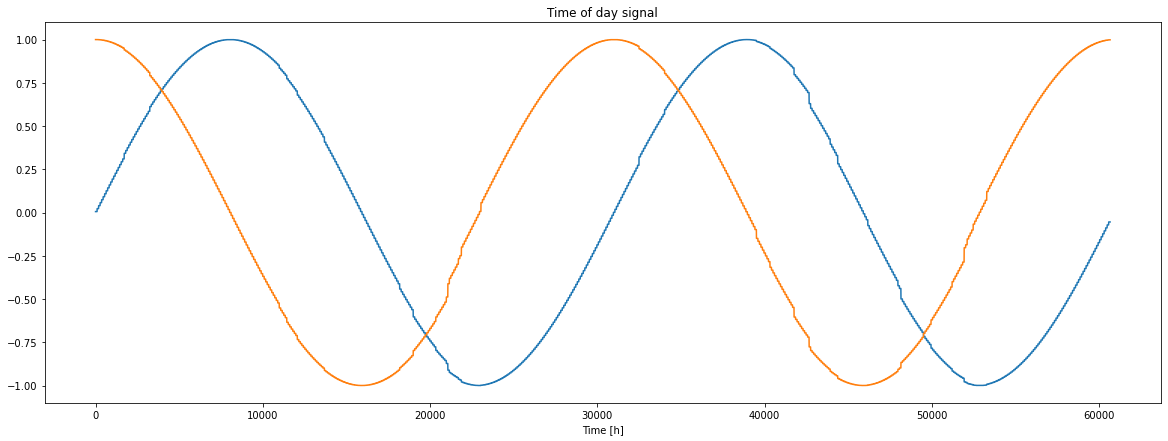

In [12]:
plt.plot(np.array(df['Year sin']))
plt.plot(np.array(df['Year cos']))
plt.xlabel('Time [h]')
plt.title('Time of day signal')

# Split the data

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

## Normalizae The Data
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So in the interest of simplicity this tutorial uses a simple average.

In [14]:
cols = ['DBA','LAR','ADR','DOW','Mon']
train_mean = train_df[cols].mean()
train_std  = train_df[cols].std()

train_df[cols] = (train_df[cols] - train_mean) / train_std
val_df[cols] = (val_df[cols] - train_mean) / train_std
test_df[cols] = (test_df[cols] - train_mean) / train_std

In [15]:
train_df.head()

,DBA,LAR,ADR,Rooms,ROH,DOW,Mon,Week sin,Week cos,Month sin,Month cos,Year sin,Year cos
DOA,,,,,,,,,,,,,
2018-01-01 00:00:00,1.712653,-0.814524,-0.814551,43.0,0.860465,-1.479057,-1.285687,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:16:00,1.674153,-0.814524,-0.814551,43.0,0.813953,-1.479057,-1.285687,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:32:00,1.635653,-0.814524,-0.788263,43.0,0.790698,-1.479057,-1.285687,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 00:48:00,1.597153,-0.814524,-0.788263,43.0,0.767442,-1.479057,-1.285687,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985
2018-01-01 01:04:00,1.558654,-0.551123,-0.551671,43.0,0.767442,-1.479057,-1.285687,-0.399892,-0.916562,-0.909308,0.416125,0.005476,0.999985


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DBA,60660.0,44.500000,25.979372,0.000000,22.000000,44.500000,67.000000,89.000000
LAR,60660.0,71.418805,38.390787,25.920000,48.600000,62.100000,75.600000,264.600000
ADR,60660.0,71.522944,38.447620,27.360000,48.600000,61.941667,75.600000,264.600000
Rooms,60660.0,51.168958,2.836289,32.000000,48.000000,53.000000,53.000000,53.000000
ROH,60660.0,0.447758,0.287505,0.000000,0.207547,0.415094,0.679245,1.127660
DOW,60660.0,3.000000,2.019947,0.000000,1.000000,3.000000,5.000000,6.000000
Mon,60660.0,6.491098,3.504677,1.000000,3.000000,6.000000,10.000000,12.000000
Week sin,60660.0,-0.001635,0.698284,-0.965926,-0.804598,-0.074730,0.733052,0.988831
Week cos,60660.0,-0.011262,0.715742,-0.930874,-0.866025,-0.185912,0.652287,0.999301
Month sin,60660.0,0.001597,0.709977,-0.999963,-0.691771,-0.008583,0.710135,0.999411


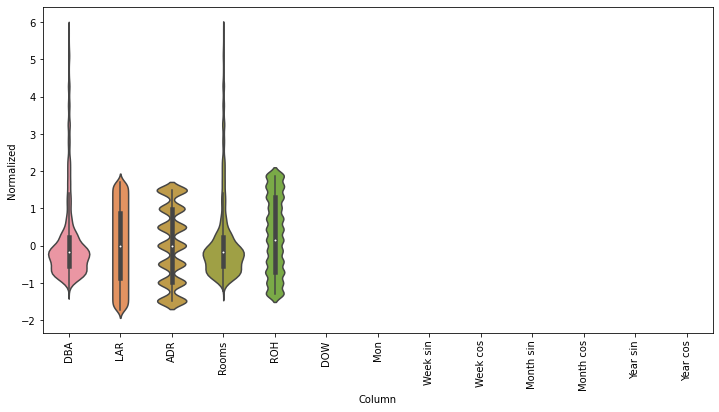

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## Split

In [19]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## Plot

In [20]:
def plot(self, model=None, plot_col='ROH', max_subplots=20):
  inputs, labels = self.example
  plt.figure(figsize=(30, 40))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(20, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

## Create Datasets

In [21]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=90,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Multistep Models

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): None

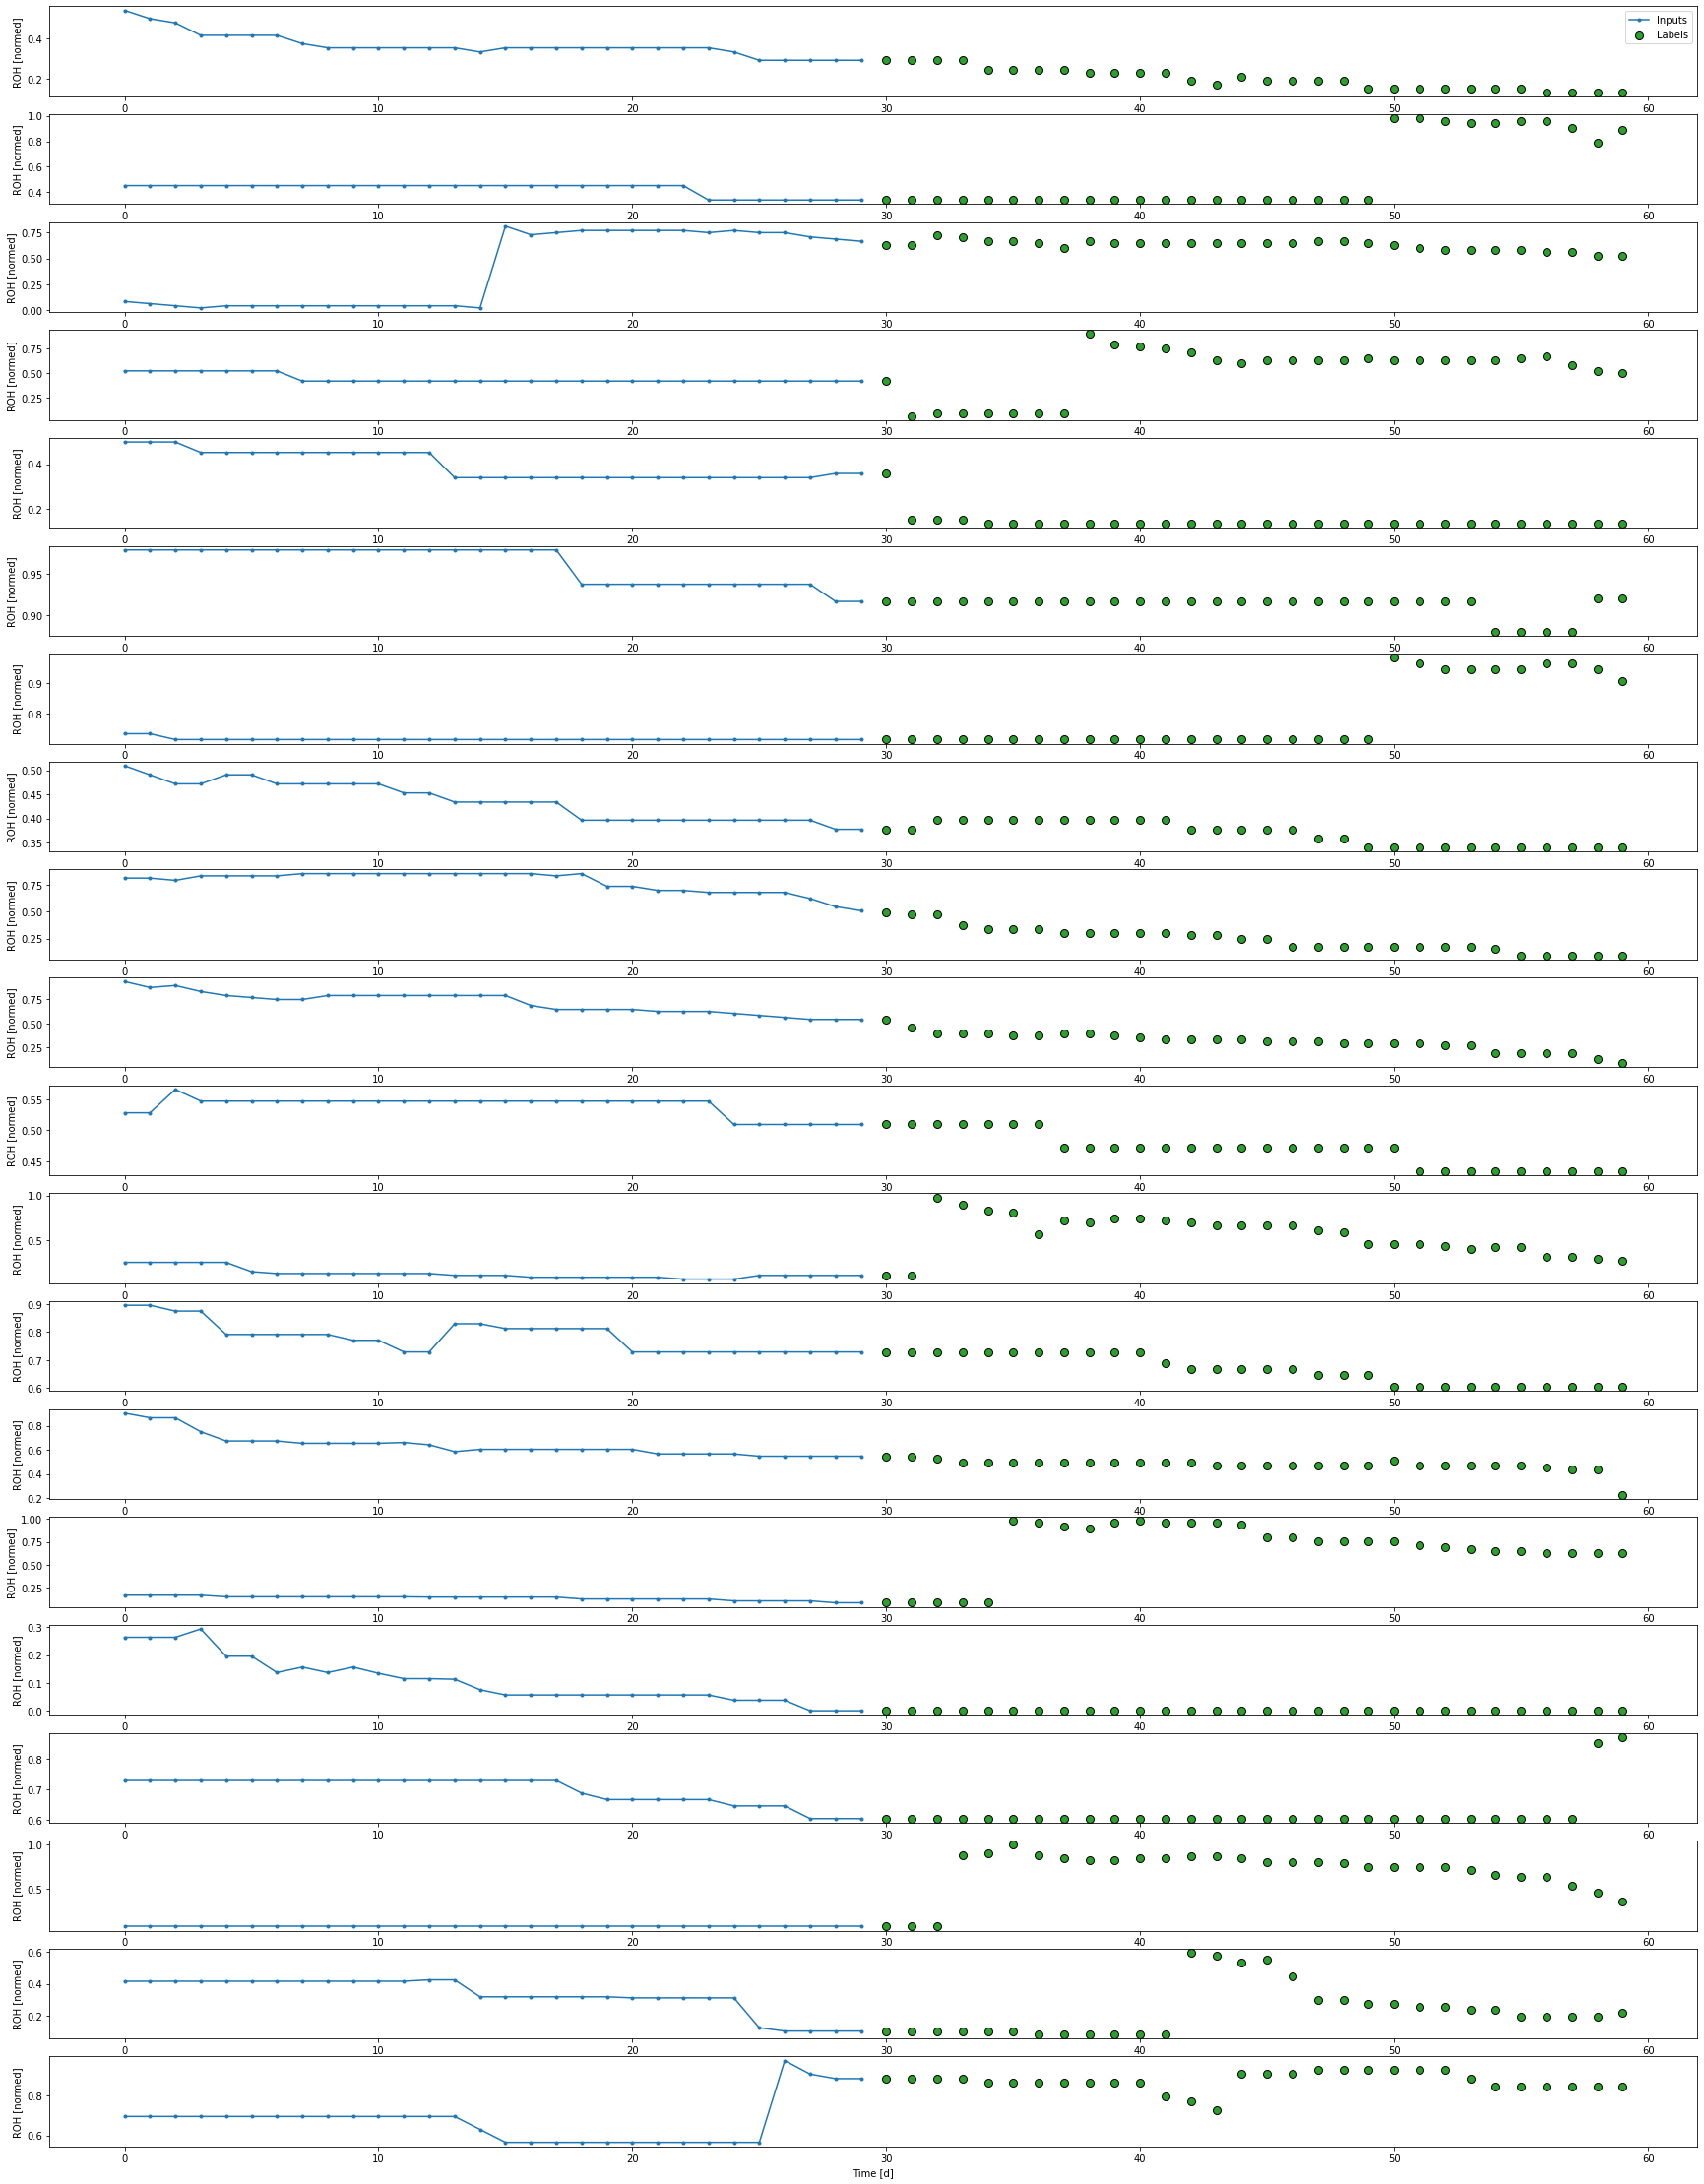

In [24]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [25]:
multi_val_performance = {}
multi_performance = {}

135/135 [==============================] - 0s 3ms/step - loss: 0.5085 - mean_absolute_error: 0.2952 - root_mean_squared_error: 0.7131


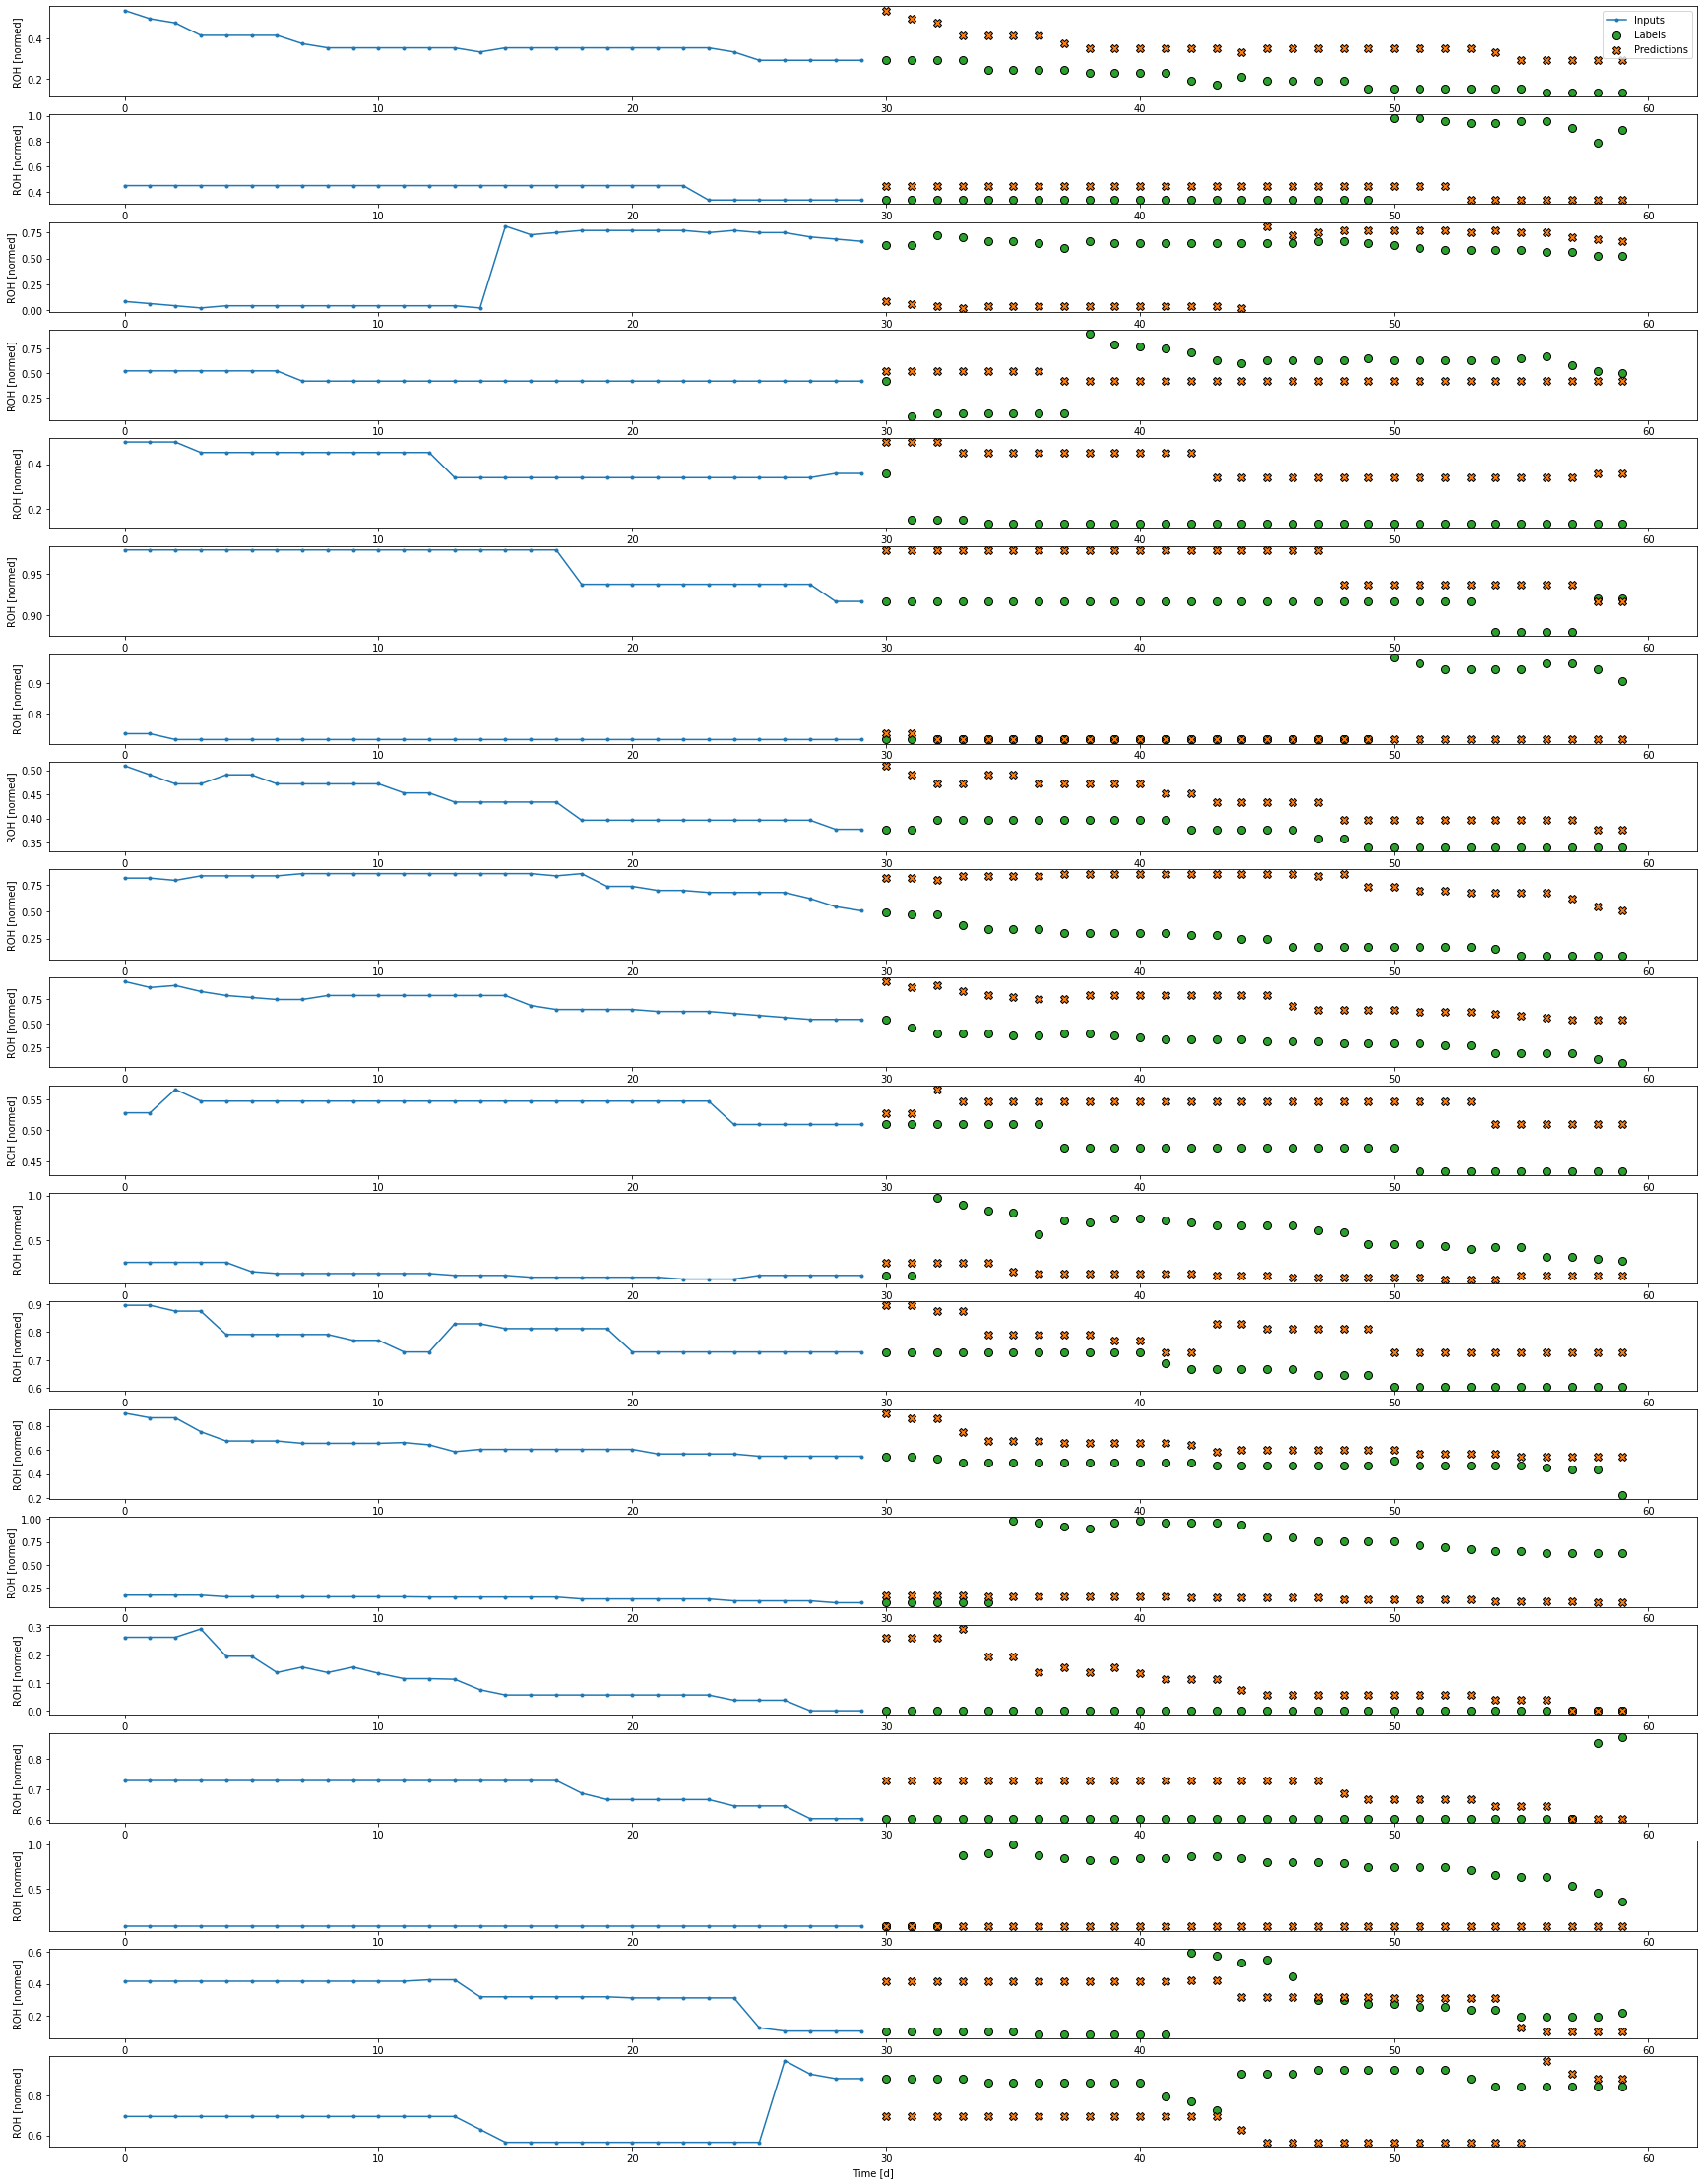

In [26]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

135/135 [==============================] - 1s 7ms/step - loss: 0.2127 - mean_absolute_error: 0.2620 - root_mean_squared_error: 0.4612


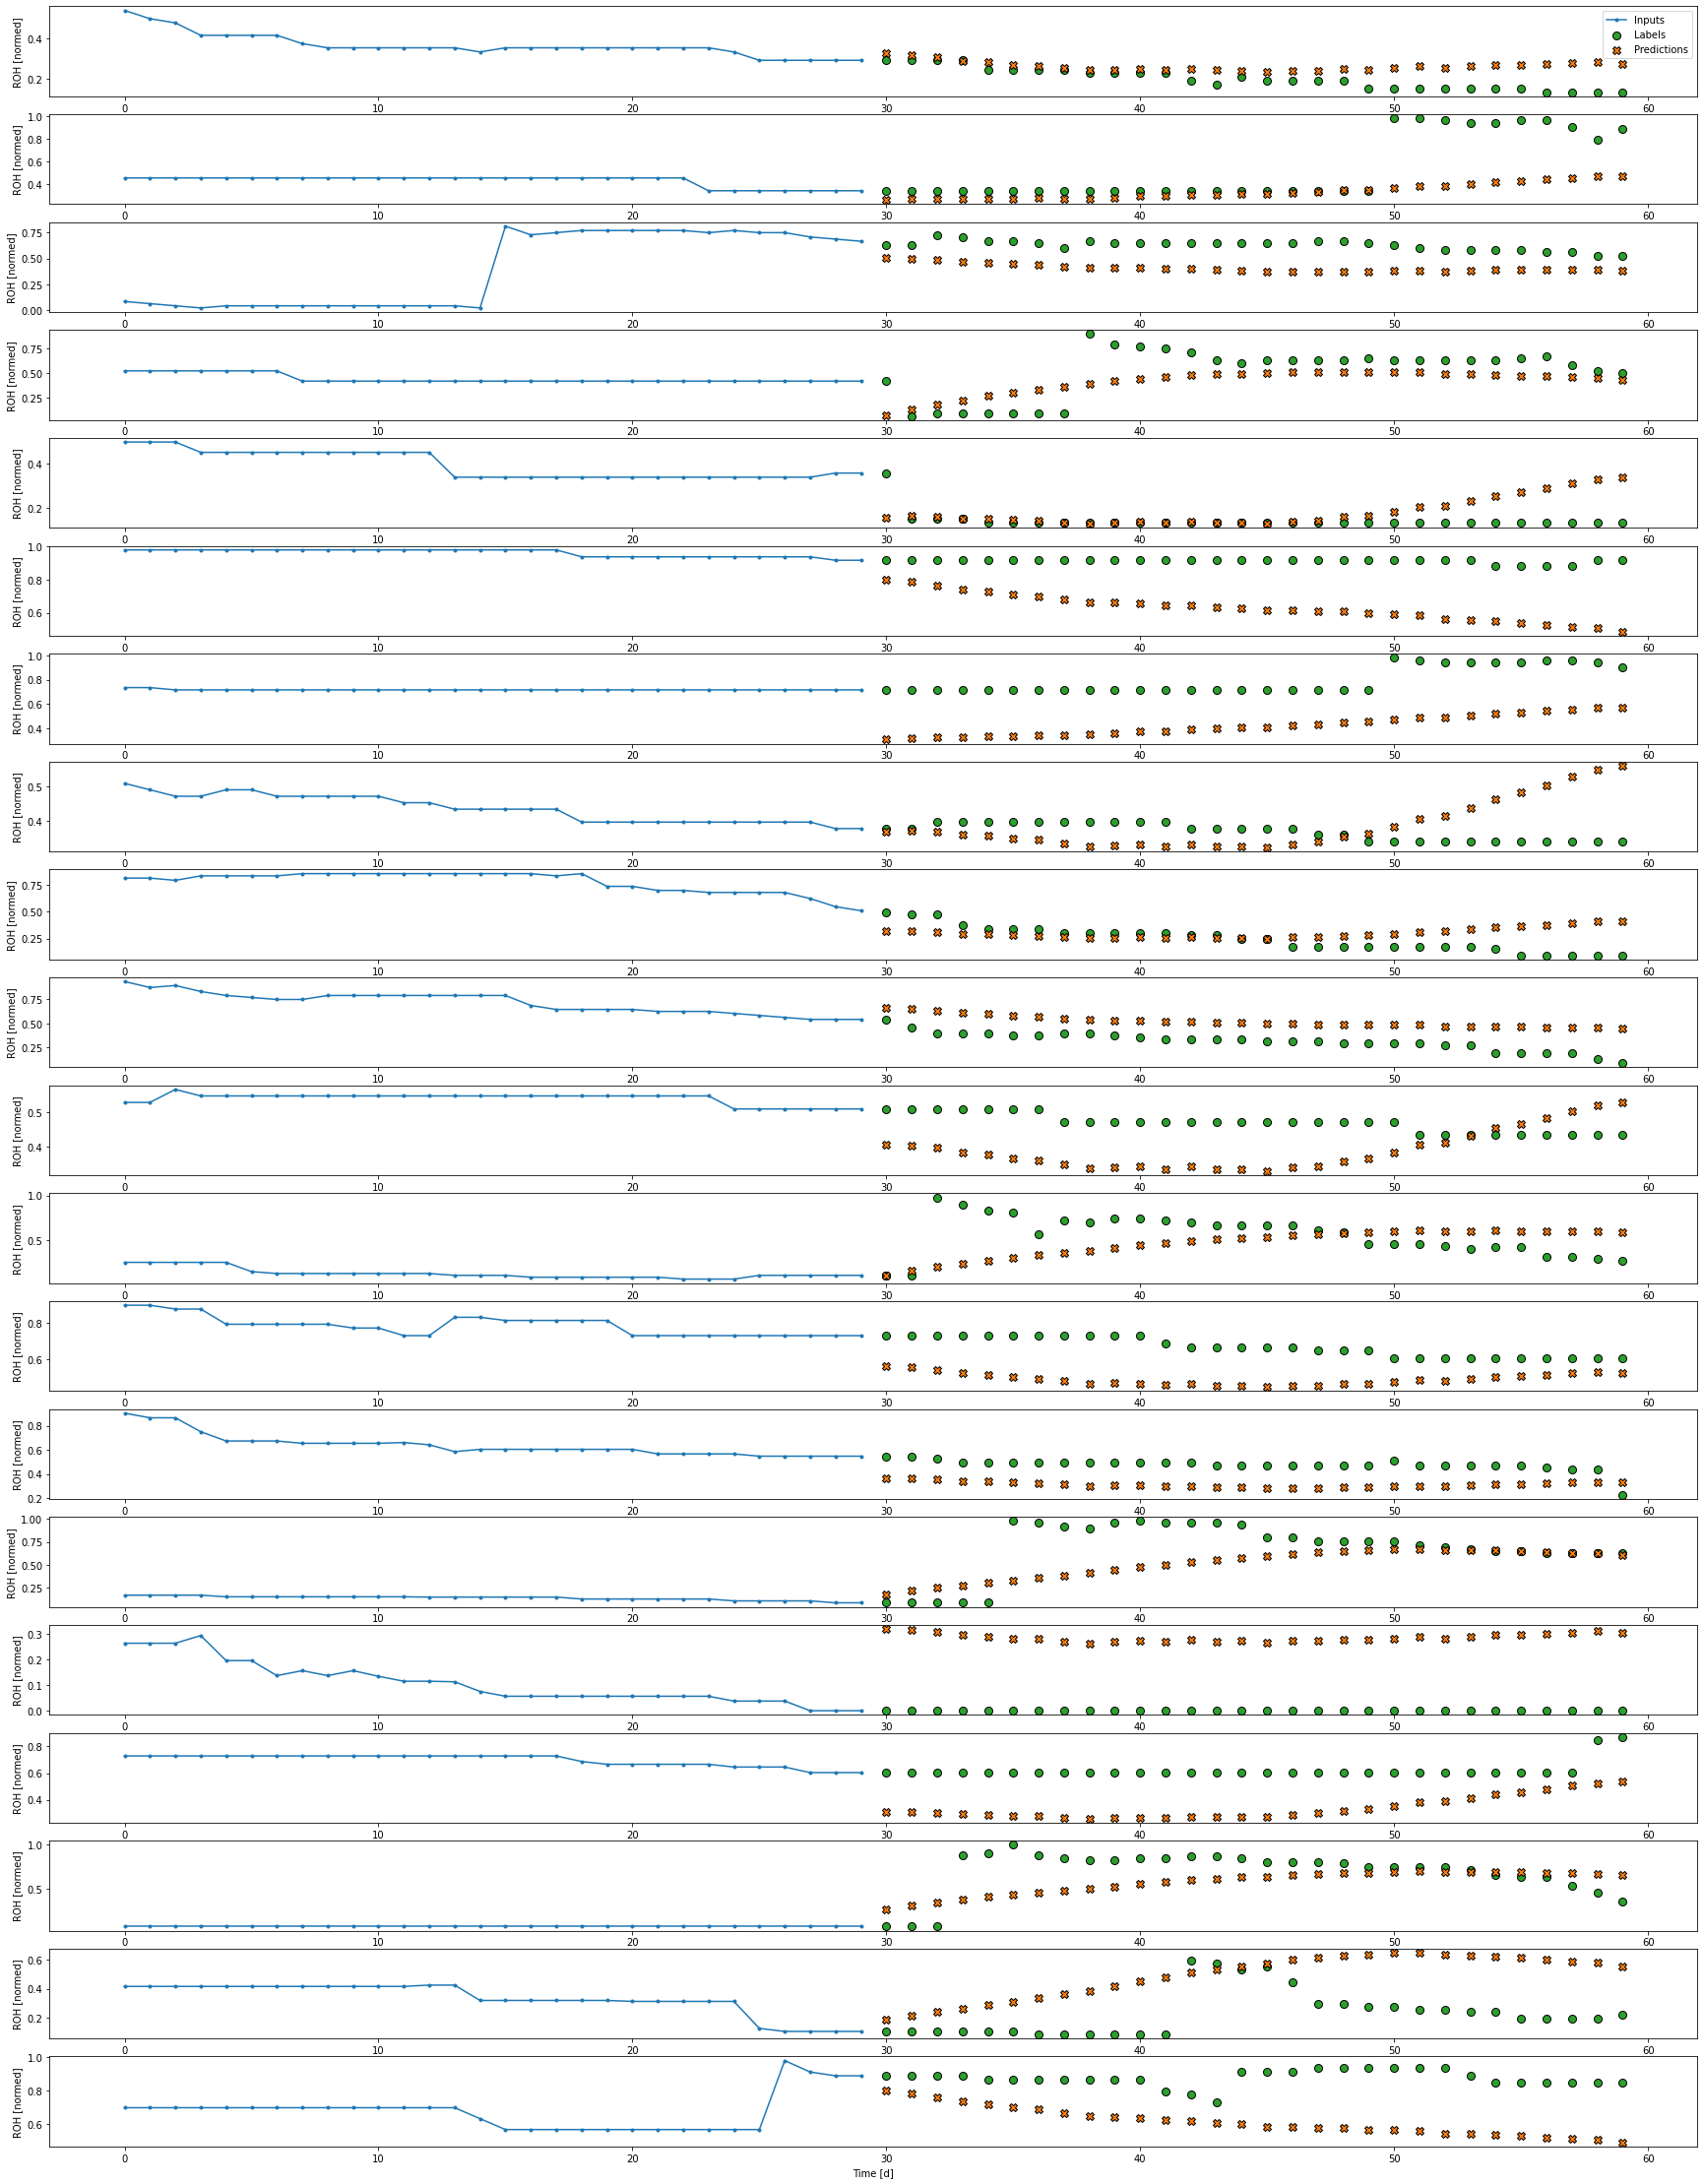

In [27]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [28]:
for name, value in multi_performance.items():
    print(f'{name:8s}: MAE :: {value[1]:0.4f}, RMSE :: {value[2]:0.4f}')

Repeat  : MAE :: 0.4375, RMSE :: 1.2391
LSTM    : MAE :: 0.3802, RMSE :: 0.8247
